# EZyRB Tutorial

In this tutorial we will show the typical workflow for the construcion of the Reduced Order Model based only on the outputs of the higher-order model.
We consider a parametric steady heat conduction problem in a two-dimensional domain $\Omega$. While in this tutorial we are going to focus on the data-driven approach, the same problem can be tackled in an intrusive manner (with the Reduced Basis method) using the [RBniCS](https://gitlab.com/RBniCS/RBniCS), as demonstrated in this [RBniCS tutorial](https://gitlab.com/RBniCS/RBniCS/tree/master/tutorials/01_thermal_block).<br>
This book is therefore exhaustively discussed in the book  *Certified reduced basis methods for parametrized partial differential equations*, J.S. Hesthaven, G. Rozza, B. Stamm, 2016, Springer. An additional description is available also at [https://rbnics.gitlab.io/RBniCS-jupyter/tutorial_thermal_block.html]().

Since the good documentation already available for this problem and since the data-driven methodologies we will take into consideration, we just summarize the model to allow a better understanding.

The domain is depicted below:

<img src="pictures/tut1_sketch.png" alt="Drawing" style="width: 300px;"/>

where:
 - the first parameter $\mu_o$ controls the conductivity in the circular subdomain $\Omega_0$;
 - the second parameter $\mu_1$ controls the flux over $\Gamma_\text{base}$.


### Initial setting

First of all import the required packages: we need the standard Numpy and Matplotlib, and some classes from EZyRB. In the EZyRB framework, we need three main ingredients to construct a reduced order model:
 - an initial database where the snapshots are stored;
 - a reduction method to reduce the dimensionality of the system, in this tutorial we will use the proper orthogonal decomposition (POD) method;
 - an approximation method to extrapolate the parametric solution for new parameters, in this tutorial we will use a radial basis function (RBF) interpolation.

In [1]:
import numpy as np
import matplotlib.tri as mtri
import matplotlib.pyplot as plt

from ezyrb import POD, RBF, Database
from ezyrb import ReducedOrderModel as ROM
%matplotlib inline

## Offline phase

In the *offline* phase, we need some samples of the parametric high-fidelity model. In this case, we extract 8 snapshots from the numerical model implemented in **FEniCS**, and we import them and the related parameters.

In [2]:
snapshots = np.load('data/tut1_snapshots.npy')
param = np.load('data/tut1_mu.npy')
print(snapshots.shape, param.shape)

(8, 304) (8, 2)


Moreover, to visualize the solution (both the higher-order one and the reduced one), we import also the mesh information to be able to create the triangulation. We underline this additional step is related only to plotting purpose, and not mandatory for the reduced space generation.

In [3]:
tri = np.load('data/tut1_triangles.npy')
coord = np.load('data/tut1_coord.npy')
triang = mtri.Triangulation(coord[0],coord[1],tri)

For the sake of clarity the snapshots are plotted.

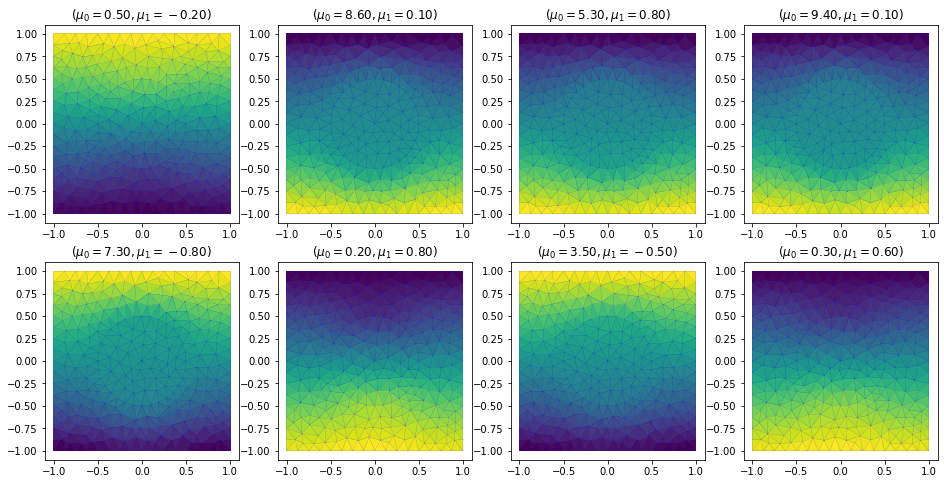

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
ax = ax.flatten()
for i in range(8):
   ax[i].triplot(triang, 'b-', lw=0.1)
   ax[i].tripcolor(triang, snapshots[i])
   ax[i].set_title('($\mu_0={:5.2f}, \mu_1={:5.2f})$'.format(*param[i]))

First of all, we create a `Database` object from the parameters and the snapshots.

In [5]:
db = Database(param, snapshots)

Then we need a reduction object, so we create a `POD` object.


In [6]:
pod = POD('svd')

Finally we instantiate the `RBF` class. These are just the standard methods, for the complete list of implementations and arguments we suggest to read the official documentation.

In [7]:
rbf = RBF()

We create the `ReducedOrderModel` (aliased to `ROM` in this tutorial) object by passing the already created objects. For clarity, we puntualize that we need to pass the **instances** and not the classes.
The `fit()` function computes the reduced model, meaning that the original snapshots in the database are projected onto the POD space and the RBF interpolator is created.

In [8]:
rom = ROM(db, pod, rbf)
rom.fit();

## Online phase
In the *online* phase we predict solution for a new parameter $\mu_\text{new}$ that is not in the training set. We just need to pass the new parameters as input of the `predict()` function.

In [9]:
new_mu = [8,   1]
pred_sol = rom.predict(new_mu)

We can so plot the predicted solution for a fixed parameter...

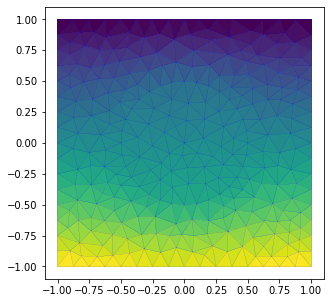

In [10]:
plt.figure(figsize=(5, 5))
plt.triplot(triang, 'b-', lw=0.1)
plt.tripcolor(triang, pred_sol);

... or interactively touch the input parameters to visualize the corresponding (approximated) output. For a fancy result, we need a bit of IPython black magic ([https://ipywidgets.readthedocs.io/en/latest/]()).

In [11]:
from ipywidgets import interact

def plot_solution(mu0, mu1):
    new_mu = [mu0, mu1]
    pred_sol = rom.predict(new_mu)
    plt.figure(figsize=(8, 7))
    plt.triplot(triang, 'b-', lw=0.1)
    plt.tripcolor(triang, pred_sol)
    plt.colorbar()

interact(plot_solution, mu0=8, mu1=1);

interactive(children=(IntSlider(value=8, description='mu0', max=24, min=-8), IntSlider(value=1, description='m…

## Error Approximation & Improvement

At the moment, we used a database which is composed by 8 files. we would have an idea of the approximation accuracy we are able to reach with these high-fidelity solutions. Using the *leave-one-out* strategy, an error is computed for each parametric point in our database and these values are returned as array. 

In [12]:
for pt, error in zip(rom.database.parameters, rom.loo_error()):
    print(pt, error)

[ 0.5 -0.2] 1.4659459069615297
[8.6 0.1] 2.370351451407335
[5.3 0.8] 9.277811731465327
[9.4 0.1] 2.6385920620832723
[ 7.3 -0.8] 9.9400254123629
[0.2 0.8] 1.6046247028303395
[ 3.5 -0.5] 1.9574356157818482
[0.3 0.6] 0.9731879770201903


Moreover, we can use the information about the errors to locate the parametric points where we have to compute the new high-fidelity solutions and add these to the database in order to optimally improve the accuracy.

In [13]:
rom.optimal_mu()

[array([ 6.07244184, -0.07123822])]

These function can be used to achieve the wanted (estimated) accuracy.